In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [117]:
df_final = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_20250423.parquet')

In [118]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120779 entries, 0 to 1120778
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id_technique            1120779 non-null  object        
 1   id                      1120779 non-null  object        
 2   debit                   1120779 non-null  int64         
 3   longueur                1120779 non-null  int64         
 4   taux_occupation         1120779 non-null  float64       
 5   code_couleur            1120779 non-null  int64         
 6   nom_du_troncon          1120779 non-null  object        
 7   etat_du_trafic          1120779 non-null  object        
 8   temps_de_parcours       1120779 non-null  int64         
 9   vitesse                 1120779 non-null  int64         
 10  geo_point_2d            1120779 non-null  object        
 11  geometrie               1120779 non-null  object        
 12  shape_geo     

## Filtrer sur un tronçon pour commencer, hors vacances scolaires

In [119]:
df = df_final[(df_final['nom_du_troncon'] == 'Vannes I7') & (df_final['is_vacances'] == 0)]

### Remettre données en ordre chrono

IMPORTANT car chaque donnée dépend de celle qui la précède

In [120]:
df = df.sort_values('horodatage')
df = df.set_index('horodatage')

#### Vérification des Nan

In [121]:
df['taux_occupation'].isna().sum()

0

In [122]:
df.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,epsg_reg,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,heure,pluie,is_weekend
horodatage,,,,,,,,,,,,,,,,,,,,,
2025-02-24 00:28:00,70-20250224T002800,70,60,295,1.2,3,Vannes I7,fluide,52,20,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,0,False,False
2025-02-24 03:47:00,70-20250224T034700,70,60,295,1.2,3,Vannes I7,fluide,-1,-1,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,3,False,False
2025-02-24 04:22:00,70-20250224T042200,70,60,295,0.8,3,Vannes I7,fluide,48,22,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,4,False,False
2025-02-24 04:52:00,70-20250224T045200,70,120,295,2.0,3,Vannes I7,fluide,62,17,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,4,False,False
2025-02-24 05:52:00,70-20250224T055200,70,60,295,1.2,3,Vannes I7,fluide,67,16,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,5,False,False


#### Fréquence des données

In [123]:
diffs = df.index.to_series().diff()

# Compter la fréquence de chaque intervalle
interval_counts = diffs.value_counts()
print(interval_counts)


horodatage
0 days 00:15:00    235
0 days 00:10:00    155
0 days 00:20:00    108
0 days 00:14:00     82
0 days 00:25:00     72
                  ... 
0 days 04:35:00      1
0 days 04:40:00      1
0 days 02:16:00      1
0 days 03:05:00      1
0 days 02:29:00      1
Name: count, Length: 73, dtype: int64


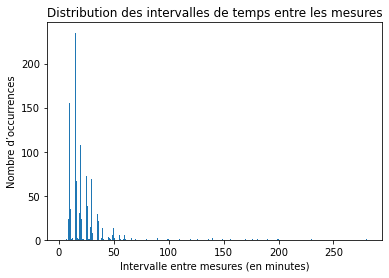

In [124]:
interval_counts.index = interval_counts.index.total_seconds() / 60  # convertir en minutes
plt.bar(interval_counts.index, interval_counts.values)
plt.xlabel('Intervalle entre mesures (en minutes)')
plt.ylabel('Nombre d’occurrences')
plt.title('Distribution des intervalles de temps entre les mesures')
plt.show()

### Resample des heures à 15 minutes et ingestion de données interpolées

In [125]:
df_resampled = df[['taux_occupation']].resample('15min').mean().interpolate()

#### Analyse de l'impact sur les données

In [126]:
print("Original :")
print(df['taux_occupation'].describe())
print("\nResamplé :")
print(df_resampled['taux_occupation'].describe())


Original :
count    1157.000000
mean       17.877010
std        19.994611
min         0.400000
25%         3.700000
50%        10.800000
75%        22.000000
max        91.600000
Name: taux_occupation, dtype: float64

Resamplé :
count    1822.000000
mean       14.957286
std        18.599754
min         0.400000
25%         1.928070
50%         7.900000
75%        18.300000
max        91.600000
Name: taux_occupation, dtype: float64


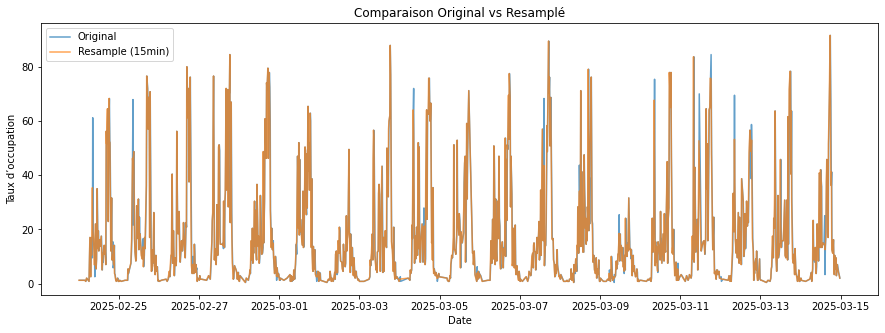

In [127]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.7)
plt.plot(df_resampled.index, df_resampled['taux_occupation'], label='Resample (15min)', alpha=0.7)
plt.legend()
plt.title('Comparaison Original vs Resamplé')
plt.xlabel('Date')
plt.ylabel('Taux d’occupation')
plt.show()


On voit ici qu'il y a une perte d'information sur les pics de circulation

In [128]:
# Réinterpolation de l'original sur les timestamps resamplés
df_interp = df.reindex(df_resampled.index).interpolate()

# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df_interp['taux_occupation'], df_resampled['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original réinterpolé vs Resamplé) : {mae}")


MAE (Original réinterpolé vs Resamplé) : 12.59785834603353


<ipython-input-128-1a980911a4da>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interp = df.reindex(df_resampled.index).interpolate()


Le MAE (Erreur Absolue Moyenne) mesure la distance moyenne entre les valeurs prédites et les valeurs réelles. Et ici elle est trop élevèe, le modèl se trompe en moyenne de 12.6 points sur une échelle qui monte jusqu’à 100.
Donc ça représente une erreur moyenne de presque 75% de la moyenne.

### Resample des heures à 10 minutes et ingestion de données interpolées

In [129]:
df_resampled_10min = df[['taux_occupation']].resample('10min').mean().interpolate()

#### Analyse d'impact

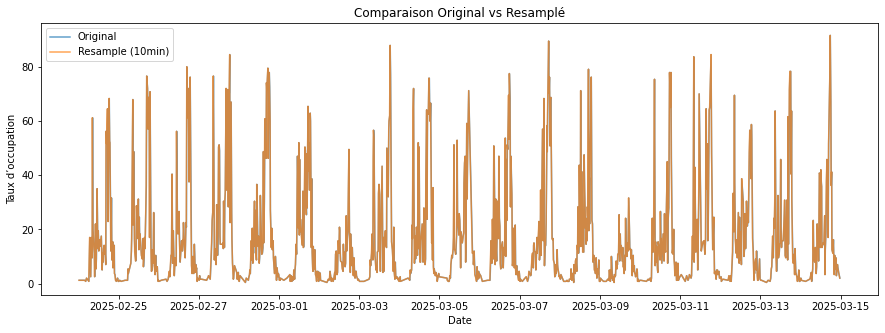

In [130]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.7)
plt.plot(df_resampled_10min.index, df_resampled_10min['taux_occupation'], label='Resample (10min)', alpha=0.7)
plt.legend()
plt.title('Comparaison Original vs Resamplé')
plt.xlabel('Date')
plt.ylabel('Taux d’occupation')
plt.show()

le resemple cache complétement l'original, on peut penser que les pics sont mieux respectés

In [131]:
# Réinterpolation de l'original sur les timestamps resamplés
df_interp = df.reindex(df_resampled_10min.index).interpolate()

# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df_interp['taux_occupation'], df_resampled_10min['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original réinterpolé vs Resamplé) : {mae}")

MAE (Original réinterpolé vs Resamplé) : 13.053653265909638


<ipython-input-131-e2e2ed83bf3a>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interp = df.reindex(df_resampled_10min.index).interpolate()


Le MAE est encore plus important qu'avec 15 minutes. On va tester sans interpolation

### Resample 15 et 10 minutes sans interpolation mais avec la moyenne

Forcer une fréquence régulière de 10 minutes.
Pour chaque créneau de 10 min, si plusieurs mesures tombent dedans, on fait la moyenne.
S’il n’y a pas de mesure dans un créneau : ça laisse des NaN (car on n’invente pas de valeurs).

In [132]:
df_resampled_no_interp = df[['taux_occupation']].resample('15min').mean()  # pas de interpolate()
# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df['taux_occupation'], df_resampled_no_interp['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original vs Resamplé sans interpolation) : {mae}")


MAE (Original vs Resamplé sans interpolation) : 0.2250000000000001


In [144]:
df_resampled_no_interp.isna().sum()

taux_occupation    1575
dtype: int64

In [133]:
df_resampled_no_interp = df[['taux_occupation']].resample('10min').mean()  # pas de interpolate()
# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df['taux_occupation'], df_resampled_no_interp['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original vs Resamplé sans interpolation) : {mae}")

MAE (Original vs Resamplé sans interpolation) : 0.0


Conclusion : L'interpolation cachait trop les pics et générait une trop grande perte d'info. Avec le resample, j'ai gééré des donnée de taux d'occupation vide que je dois choisir de remplir soit par ffill soit par interpolation ce qui peut fausser les données. 

## Arrondir au quart d'heure le plus proche

In [134]:
df['horodate_rounded'] = df.index.round('15min')
df_grouped = df.groupby('horodate_rounded')[['taux_occupation']].mean()

In [135]:
df.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,heure,pluie,is_weekend,horodate_rounded
horodatage,,,,,,,,,,,,,,,,,,,,,
2025-02-24 00:28:00,70-20250224T002800,70,60,295,1.2,3,Vannes I7,fluide,52,20,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,0,False,False,2025-02-24 00:30:00
2025-02-24 03:47:00,70-20250224T034700,70,60,295,1.2,3,Vannes I7,fluide,-1,-1,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,3,False,False,2025-02-24 03:45:00
2025-02-24 04:22:00,70-20250224T042200,70,60,295,0.8,3,Vannes I7,fluide,48,22,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,4,False,False,2025-02-24 04:15:00
2025-02-24 04:52:00,70-20250224T045200,70,120,295,2.0,3,Vannes I7,fluide,62,17,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,4,False,False,2025-02-24 04:45:00
2025-02-24 05:52:00,70-20250224T055200,70,60,295,1.2,3,Vannes I7,fluide,67,16,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,5,False,False,2025-02-24 05:45:00


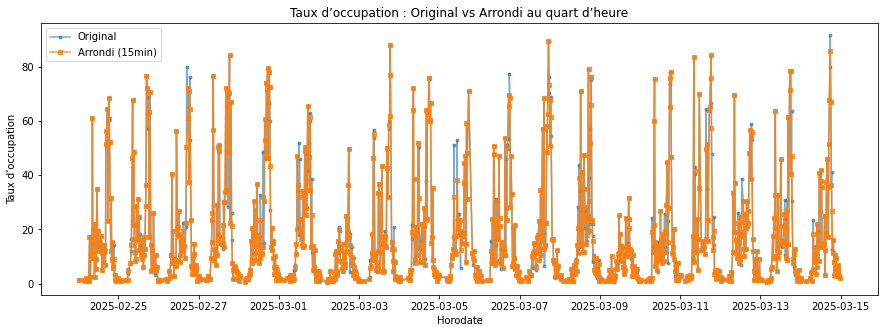

In [136]:
# Analyse de l'impact

plt.figure(figsize=(15, 5))

# Données originales
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.6, marker='o', linestyle='-', markersize=3)

# Données arrondies + moyennées
plt.plot(df_grouped.index, df_grouped['taux_occupation'], label='Arrondi (15min)', alpha=0.8, marker='s', linestyle='-', markersize=4)

plt.legend()
plt.title('Taux d’occupation : Original vs Arrondi au quart d’heure')
plt.xlabel('Horodate')
plt.ylabel('Taux d’occupation')
plt.show()


In [137]:
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE : {mae:.2f}")

MAE : 0.00


Globalement, la forme de la série est respectée, mais il ya une perte d’info fine sur les pics violents.

## Essai avec 10 min

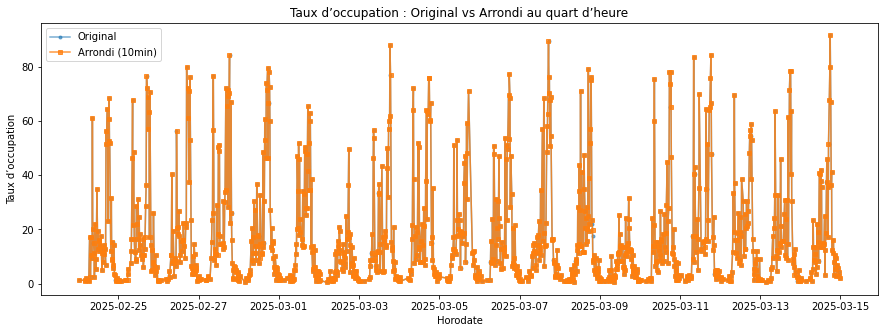

In [138]:
# Essai à 10 minutes
df['horodate_rounded'] = df.index.round('10min')
# Grouper si jamais 2 heure se retrouve être identique
df_grouped = df.groupby('horodate_rounded')[['taux_occupation']].mean()

# Analyse de l'impact

plt.figure(figsize=(15, 5))

# Données originales
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.6, marker='o', linestyle='-', markersize=3)

# Données arrondies + moyennées
plt.plot(df_grouped.index, df_grouped['taux_occupation'], label='Arrondi (10min)', alpha=0.8, marker='s', linestyle='-', markersize=4)

plt.legend()
plt.title('Taux d’occupation : Original vs Arrondi au quart d’heure')
plt.xlabel('Horodate')
plt.ylabel('Taux d’occupation')
plt.show()

Visuellement, la série orange (arrondie) colle plus près de la série originale (bleue) que dans le cas du quart d’heure.
Les pics sont mieux respectés : moins d'info perdu

In [139]:
df.columns

Index(['id_technique', 'id', 'debit', 'longueur', 'taux_occupation',
       'code_couleur', 'nom_du_troncon', 'etat_du_trafic', 'temps_de_parcours',
       'vitesse', 'geo_point_2d', 'geometrie', 'shape_geo', 'type_geo',
       'coordinates_geo', 'jour', 'is_vacances', 'is_ferie', 'temperature_2m',
       'visibility', 'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech',
       'code_qual', 'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone',
       'code_zone', 'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10',
       'code_pm25', 'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg',
       'etat_indice', 'geom_type', 'geom_coordinates', 'geo_point_2d_lon',
       'geo_point_2d_lat', 'has_event_near_troncon', 'heure', 'pluie',
       'is_weekend', 'horodate_rounded'],
      dtype='object')

In [140]:
# Visualiser l'erreur
# On ajoute la valeur moyenne calculée à chaque point original (via join)
df_with_grouped = df[['taux_occupation', 'horodate_rounded']].merge(
    df_grouped, left_on='horodate_rounded', right_index=True, suffixes=('', '_rounded')
)
# Calcul de l'erreur (différence absolue)
df_with_grouped['abs_error'] = abs(df_with_grouped['taux_occupation'] - df_with_grouped['taux_occupation_rounded'])

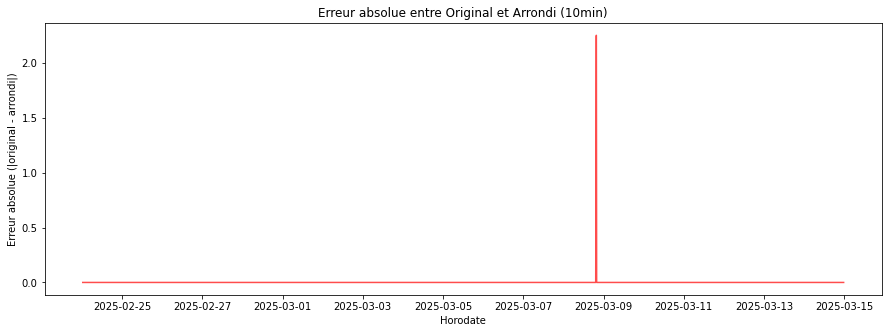

In [141]:
plt.figure(figsize=(15, 5))
plt.plot(df_with_grouped.index, df_with_grouped['abs_error'], color='red', alpha=0.7)
plt.title('Erreur absolue entre Original et Arrondi (10min)')
plt.xlabel('Horodate')
plt.ylabel('Erreur absolue (|original - arrondi|)')
plt.show()


L'arrondi à 10 minutes respecte très bien les valeurs originales dans presque tous les cas.

Mais parfois, il y a plusieurs mesures différentes dans la même tranche de 10 minutes, et avec la moyenne, on perd l’amplitude de certaines variations rapides 

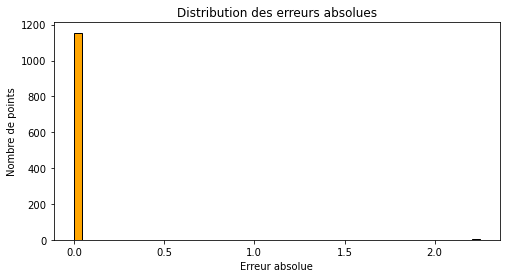

In [142]:
# Histogramme des erreurs
plt.figure(figsize=(8, 4))
plt.hist(df_with_grouped['abs_error'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution des erreurs absolues')
plt.xlabel('Erreur absolue')
plt.ylabel('Nombre de points')
plt.show()


Écrasante majorité des erreurs très faibles (quasi nulles).
Quelques rares grosses erreurs (probablement des cas où plusieurs valeurs très différentes sont tombées dans le même créneau de 10 min).

In [143]:
# Repérer les 10 cas avec l’erreur la plus forte
df_with_grouped.sort_values('abs_error', ascending=False).head(10)

,taux_occupation,horodate_rounded,taux_occupation_rounded,abs_error
horodatage,,,,
2025-03-08 19:42:00,17.5,2025-03-08 19:40:00,19.75,2.25
2025-03-08 19:38:00,22.0,2025-03-08 19:40:00,19.75,2.25
2025-03-08 04:42:00,0.8,2025-03-08 04:40:00,0.80,0.00
2025-03-08 19:18:00,23.3,2025-03-08 19:20:00,23.30,0.00
2025-03-08 18:52:00,76.2,2025-03-08 18:50:00,76.20,0.00
2025-03-08 18:37:00,75.0,2025-03-08 18:40:00,75.00,0.00
2025-03-08 18:23:00,57.0,2025-03-08 18:20:00,57.00,0.00
2025-03-08 18:12:00,52.0,2025-03-08 18:10:00,52.00,0.00
2025-03-08 17:52:00,22.0,2025-03-08 17:50:00,22.00,0.00


Les MAE sont très faible, ce qui signifie que l'ecart entre le reel est l'arrondi est faible.
Cette méthode conserve le mieux l'intégrité des données

# Conclusion
La méthode round est retenue car 
- Pas de données artificielles
- Pas besoin de remplir les trous avec des valeurs inventées (comme le ferait une interpolation).
- On garde uniquement les points réellement mesurés, mais on réaligne leurs horaires sur une grille régulière.